In [1]:
# get api key from your .env file
import os
import requests

from dotenv import load_dotenv  # if missing this module, simply run `pip install python-dotenv`

load_dotenv()
API_KEY = os.getenv('POLYGON_API_KEY')
ALPHA_ADVANTAGE_API_KEY = os.getenv('ALPHA_ADVANTAGE_API_KEY')

print(API_KEY)
print(ALPHA_ADVANTAGE_API_KEY)

eYFFqMh3r0gYcJ4hBsJQTxsSS8s10mZB
HJ48VNC66Z0Q01V9


<h3> Dataset One: POLYGON Daily Data </h3>

Pulled from Polygon per day, with open, high, low, and close for the entire market (total 10k+). Polygon has a API call limit of 5 / minute, so I can write a script to make five calls per minute to gather a year of data. 

<b> Potential limitations: </b> With daily data, perhaps the data will not be granular enough to provide accurate results.


<b> After EDA: </b> Seems like using whole market data will be far too many data processing. Even with just 10 days of data, takes significant computing. Will be much more effective to narrow down to a handful of specific stocks, or focus on a specific industry.

In [2]:
import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_data(year, month, day, numDays):
    waitCounter = 0
    return_df = pd.DataFrame()
    date = datetime.date(year, month, day)
    for i in range(numDays):
        payload = {'adjusted': 'true', 'include_otc': 'false','apiKey':API_KEY}
        URL = 'https://api.polygon.io/v2/aggs/grouped/locale/us/market/stocks/' + date.strftime("%Y-%m-%d")
        req = requests.get(URL, params=payload)

        if "results" in req.json():
            dat = (req.json())['results']

            dat_df = pd.DataFrame(dat)
            dat_df['date'] = date.strftime("%Y-%m-%d")
            return_df = pd.concat([return_df, dat_df], ignore_index=True)

        date += datetime.timedelta(days=1)
        if(date.weekday() == 5):
            date += datetime.timedelta(days=2)

        # 5 API call / minute limit for free account
        waitCounter += 1
        if(waitCounter >= 5):
            time.sleep(65)
            waitCounter = 0
        
    return return_df


In [3]:
# daily_dat = get_data(2023, 1, 9, 9)
# daily_dat.to_json('daily_data.json', orient = 'split', compression = 'infer', index = 'true')

df = pd.read_json('daily_data.json', orient ='split', compression = 'infer')


,T,v,vw,o,c,h,l,t,n,date
0,TTMI,394280.0,16.1078,15.9600,16.0800,16.3350,15.9600,1673298000000,5416.0,2023-01-09
1,OEC,485157.0,19.0627,18.6700,18.9800,19.4300,18.4500,1673298000000,8130.0,2023-01-09
2,USDU,642813.0,25.8745,25.9200,25.8800,25.9500,25.8204,1673298000000,2417.0,2023-01-09
3,BWXT,389669.0,57.4657,58.1500,57.2800,58.1800,57.0250,1673298000000,7325.0,2023-01-09
4,WRB,1298028.0,73.2759,74.2900,72.9800,74.3800,72.5900,1673298000000,15947.0,2023-01-09
...,...,...,...,...,...,...,...,...,...,...
87560,IWTR,53.0,27.1884,27.0869,27.0869,27.0869,27.0869,1674162000000,5.0,2023-01-19
87561,FEMA,8.0,25.5197,25.3800,25.3800,25.3800,25.3800,1674162000000,3.0,2023-01-19
87562,PSCM,376.0,66.9117,66.9400,66.9400,66.9400,66.9400,1674162000000,15.0,2023-01-19
87563,WGRO,0.0,NaN,20.1365,20.1365,20.1365,20.1365,1674162000000,NaN,2023-01-19


In [18]:
daily_df = df
daily_df['percent_change'] = 2 * (daily_df['c'] - daily_df['o']) / (daily_df['c'] + daily_df['o'])

# daily_df['price_change'] = 0.0
# for index, row in df.iterrows():
#    prev_daytime = row['date'] - datetime.timedelta(days=1)
#    if(prev_daytime in df['date'].unique()):
#        prev_day = daily_df.where((daily_df['T'] == row['T']) & (daily_df['date'] == prev_daytime))
#        row['price_change'] = row['vw'] - prev_day['vw']


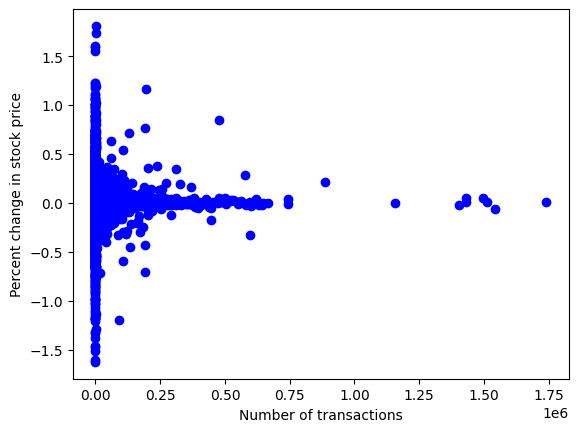

In [8]:
# see if # of transactions has an impact of percent change

plt.scatter(daily_df['n'], daily_df["percent_change"], color = "Blue")
plt.xlabel("Number of transactions")
plt.ylabel("Percent change in stock price")
plt.show()

In [16]:
daily_df.sort_values(by=['price_change'], ascending=False)

,T,v,vw,o,c,h,l,t,n,date,percent_change,price_change
23375,BRK.A,3606.0,482236.1384,482167.0050,483990.0000,484896.9900,478730.0000,1673470800000,3588.0,2023-01-11,0.003774,4932.2766
33328,BRK.A,3778.0,485883.7317,486177.0050,482860.0000,488688.0000,480600.0000,1673557200000,3733.0,2023-01-12,-0.006846,3647.5933
14765,SEB,890.0,3910.2465,3799.9900,3978.6400,3985.6200,3790.0000,1673384400000,507.0,2023-01-10,0.045934,122.9269
29388,NVR,22282.0,4893.0841,4850.0000,4914.5100,4934.9900,4794.3200,1673470800000,3846.0,2023-01-11,0.013213,98.5304
27486,SEB,1022.0,3991.8449,3958.9100,4046.8000,4047.2800,3889.3200,1673470800000,777.0,2023-01-11,0.021957,81.5984
...,...,...,...,...,...,...,...,...,...,...,...,...
87547,NTZG,0.0,NaN,26.6735,26.6735,26.6735,26.6735,1674162000000,NaN,2023-01-19,0.000000,NaN
87551,ARVR,0.0,NaN,25.8705,25.8705,25.8705,25.8705,1674162000000,NaN,2023-01-19,0.000000,NaN
87556,USBF,2.0,86.4550,86.3900,86.3900,86.3900,86.3900,1674162000000,2.0,2023-01-19,0.000000,NaN
87557,CIRC,0.0,NaN,50.8174,50.8174,50.8174,50.8174,1674162000000,NaN,2023-01-19,0.000000,NaN


<h3> Dataset Two: POLYGON Aggregates </h3>

Pulled from POLYGON per stock, minute by minute data for an individual stock. If I choose to focus on a specific market and pick a set of specific stocks, can create a script to pull all of the data. Limit of 50000 base aggregate bars (by minute) per query. Due to this, must pull data in two-month chunks (which means that we can approximately pull a year of data for a single stock in a bit over a minute).

In [19]:
from dateutil.relativedelta import relativedelta

payload = {'adjusted': 'true', 'sort': 'asc','apiKey':API_KEY, 'limit':'50000'}
date_start = '2022-11-01'
date_end = '2023-01-01'
stock = 'AAPL'
URL = 'https://api.polygon.io/v2/aggs/ticker/' + stock + '/range/1/minute/' + date_start + '/' + date_end 

print(URL)

minute_req = requests.get(URL, params=payload)

def get_individual_stock(start_year, start_month, numMonths, stocks):
    
    for stock in stocks:
        waitCounter = 0
        return_df = pd.DataFrame()
        date = datetime.date(start_year, start_month, 1)
        for i in range(numMonths / 2):

            end_date = date + relativedelta(months=2) - datetime.timedelta(days=1)
            URL = 'https://api.polygon.io/v2/aggs/ticker/' + stock + '/range/1/minute/' + date_start + '/' + date_end 
            req = requests.get(URL, params=payload)

            if "results" in req.json():
                dat = (req.json())['results']

                dat_df = pd.DataFrame(dat)
                dat_df['date'] = date.strftime("%Y-%m-%d")
                return_df = pd.concat([return_df, dat_df], ignore_index=True)

            date += datetime.timedelta(days=1)
            if(date.weekday() == 5):
                date += datetime.timedelta(days=2)

            # 5 API call / minute limit for free account
            waitCounter += 1
            if(waitCounter >= 5):
                time.sleep(65)
                waitCounter = 0
            
        return return_df


https://api.polygon.io/v2/aggs/ticker/AAPL/range/1/minute/2022-11-01/2023-01-01


In [22]:
minute_json = minute_req.json()

appl_df = pd.DataFrame(minute_json['results'])

print("Null Value Present:", appl_df.isnull().values.any())

33253


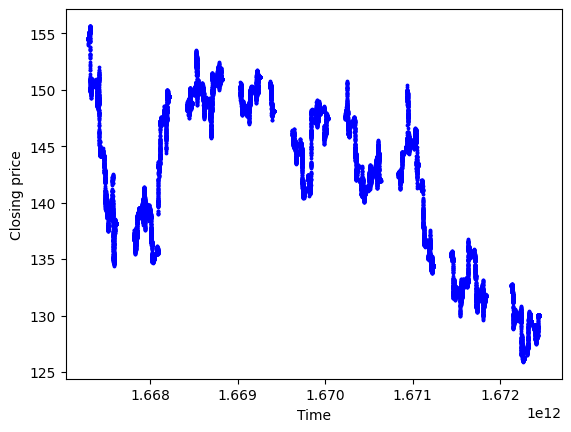

In [31]:
# see if # of transactions has an impact of percent change

plt.scatter(appl_df['t'], appl_df["c"], color = "Blue", s = 3)
plt.xlabel("Time")
plt.ylabel("Closing price")
plt.show()

<h3> Dataset Three: Alpha Advantage Fundamental Data </h3>

Pulled from 'alphadvantage' per company. If I choose to focus on a specific set of stocks, then i can pull fundamental data for a select few companies through this. This specific example is for the quarterly balance sheets for a company. I'll be able to retrieve other fundamental + stock data as well, for specific companies.

In [ ]:
advantage_payload = {'function':'BALANCE_SHEET','symbol':'AAPL','apikey':ALPHA_ADVANTAGE_API_KEY}

advantage_URL = 'https://www.alphavantage.co/query'

adv_req = requests.get(advantage_URL, params=advantage_payload)

In [ ]:
adv_json = adv_req.json()

quarterly_reports = adv_json['quarterlyReports']

print(len(quarterly_reports))